# Decomposer Test

This notebook is made for assessing the performence of the decomposer alone

## Generate QD

In [ ]:
from transformers.models.auto.tokenization_auto import AutoTokenizer
from peft import AutoPeftModelForCausalLM
from processors import ProcessorRegistry
from datasets import load_dataset
from tqdm import tqdm

from src.utils.generation import to_model_prompt, generate_batch
from src.inference.qpl.text_to_qpl import get_decomposer_generation_params, DecomposerMode
import src.utils.paths as p

# Constants
BATCH_SIZE = 8
MAX_NEW_TOKENS = 256
MODEL_CKPT = "gemma-3-4b-it-question_decomposer_ds_train_batch_size=1_gradient_accumulation_steps=1_learning_rate=0.0002_num_train_epochs=2_gradient_checkpointing=False_logging_steps=500_save_steps=5000_random_seed=1_lora=True_r=16_alpha=32_dropout=0.05/checkpoint-20958"
MODEL_PATH = p.TRAINED_MODELS_DIR / MODEL_CKPT
DATASET_ID = "bgunlp/question_decomposer_ds"
MAX_RETRIES = 3
MODE = DecomposerMode.GREEDY


# Load model & tokenizer
model = AutoPeftModelForCausalLM.from_pretrained(MODEL_PATH).cuda()
model = model.eval()
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

# Load and process data
test_dataset = list(load_dataset(DATASET_ID, split="validation"))
processor = ProcessorRegistry.get(DATASET_ID)(with_assistant=False)
chat_templates = list(map(processor.to_chat_template, test_dataset))
prompts = list(map(lambda ct: to_model_prompt(tokenizer, ct), chat_templates))

# Decompose questions
outputs = generate_batch(
    model=model,
    tokenizer=tokenizer,
    model_prompts=prompts,
    batch_size=BATCH_SIZE,
    max_new_tokens=MAX_NEW_TOKENS,
    progress_bar=tqdm(total=len(prompts), desc="Decomposing"),
    is_valid_output=(lambda i, output: test_dataset[i]['question'] != output) if MODE in [DecomposerMode.FIRST_GREEDY, DecomposerMode.SAMPLING] else None,
    max_retries=MAX_RETRIES,
    **get_decomposer_generation_params(MODE)
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Decomposing: 100%|██████████| 3028/3028 [18:43<00:00,  2.70it/s]


## Evaluate

2025-05-25 17:42:08,023 - INFO - Use pytorch device_name: cuda:0
2025-05-25 17:42:08,024 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2025-05-25 17:42:14,480 - WARNING - No valid parent found for question: What is the first name and age of every student who has a dog but does not have a cat?
2025-05-25 17:42:14,481 - WARNING - No valid parent found for question: What is the id of every student who has a cat?
2025-05-25 17:42:14,481 - WARNING - No valid parent found for question: What is the id of cats?
2025-05-25 17:42:14,482 - WARNING - No valid parent found for question: What is the id, first name and age of every student who has a dog?
2025-05-25 17:42:14,482 - WARNING - No valid parent found for question: What is the id, first name and age of all students?
2025-05-25 17:42:14,483 - WARNING - No valid parent found for question: What is the id of every student who has a dog?
2025-05-25 17:42:14,483 - WARNING - No valid parent found for question

Operator Accuracy: 0.892668428005284
Sentence Similarity (when operator is correct): 0.4491443336009979
              precision    recall  f1-score  support
aggregate      0.933333  0.898396  0.915531      561
except         0.920000  0.896104  0.907895       77
filter         0.907895  0.511111  0.654028      135
intersect      0.857143  0.837209  0.847059       43
join           0.837900  0.715400  0.771819      513
scan           0.889444  0.982747  0.933770     1449
sort           1.000000  1.000000  1.000000       48
topsort        0.894231  0.978947  0.934673      190
union          0.000000  0.000000  0.000000       11
other          0.000000  0.000000  0.000000        1
accuracy       0.892668  0.892668  0.892668        0
macro avg      0.723995  0.681991  0.696478     3028
weighted avg   0.888512  0.892668  0.885998     3028


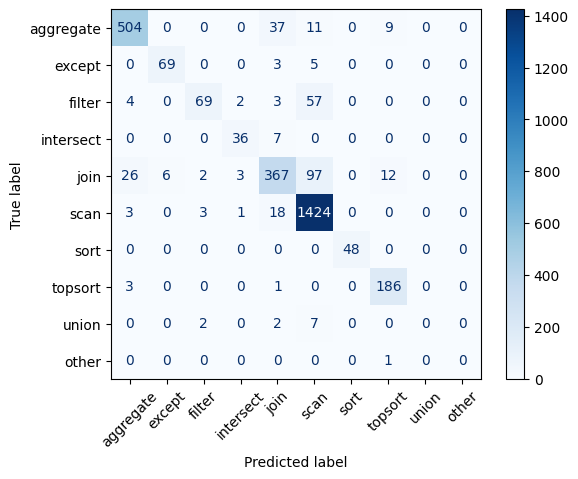

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sentence_transformers import SentenceTransformer
from sklearn.metrics import classification_report

op_correct = 0
sum_similarity = 0
sentences_count = 0

op_to_id = {
    'aggregate': 0,
    'except': 1,
    'filter': 2,
    'intersect': 3,
    'join': 4,
    'scan': 5,
    'sort': 6,
    'topsort': 7,
    'union': 8,
    'other': 9
}
id_to_op = {v: k for k, v in op_to_id.items()}

emb_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

y_pred = []
y_true = []

processor = ProcessorRegistry.get(DATASET_ID)(with_assistant=True)
chat_templates = []
for example in test_dataset:
    chat_templates.append(processor.to_chat_template(example))

for out, chat_template in tqdm(zip(outputs, chat_templates), desc="Evaluating", total=len(outputs)):
    if chat_template is None:
        continue  # Skip examples that caused recursion errors
    
    # process labels
    label = chat_template['messages'][-1]['content']
    model_lines = out.split("\n")
    label_lines = label.split("\n")

    # operator classification
    model_op_id = op_to_id.get(model_lines[0].lower(), op_to_id["other"])
    label_op_id = op_to_id.get(label_lines[0].lower(), op_to_id["other"])
    y_pred.append(model_op_id)
    y_true.append(label_op_id)

    # sentence similarity
    if model_op_id == label_op_id:
        op_correct += 1

        model_sentences = model_lines[1:]
        label_sentences = label_lines[1:]

        sentences_count += len(label_sentences)

        if len(model_sentences) != len(label_sentences):
            print("======================")
            print(out)
            print("----")
            print(label)
            print("======================")
        else:
            all_sentences = model_sentences + label_sentences
            embeddings = emb_model.encode(all_sentences, show_progress_bar=False)
            similarity_matrix = embeddings @ embeddings.T
            if len(model_sentences) == 0:
                similarity = 0
            elif len(model_sentences) == 1:
                similarity = similarity_matrix[0][1]
            else:
                similarity = max(
                    similarity_matrix[0,2] + similarity_matrix[1,3],
                    similarity_matrix[0,3] + similarity_matrix[1,2]
                ) / 2
            sum_similarity += similarity

print(f"Operator Accuracy: {op_correct / len(test_dataset)}")
print(f"Sentence Similarity (when operator is correct): {sum_similarity / op_correct}")

# Generate a classification report
report = classification_report(y_true, y_pred, output_dict=True)

# Print nicely
df = pd.DataFrame(report).transpose()
df.index = df.index.map(lambda x: id_to_op[int(x)] if x.isdigit() else x)
df['support'] = df['support'].astype(int)
print(df)

cm = confusion_matrix(y_true, y_pred, labels=list(op_to_id.values()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(op_to_id.keys()))
disp.plot(cmap=plt.cm.Blues)

plt.xticks(rotation=45)
plt.show()